# Estimation

The model object is central to the macrostructural models we use. It consists of equations and variables, jointly describing the relationship across variables. Equations can either be identities or behaviourals, and variables are either exogenous or endogenous.

The data behind the equations and variables is not itself part of the model object, although obviously essential to it.

The model itself is a system of equations comprised of behavioural equations (econometrically estimated equations that hold imprecisely (with an error) and identities which hold always exactly.

## A simple model in Modelflow
This Jupyter Notebook shows how to construct a simple "toy" model comprised of identities and behavioural equations. It shows first how to declare identities, how to estimate behavioural equations and then how to join these and the associated data into a model object. It discusses the idea of `add-factors` and how to initialize them and then briefly builds the toy model, and runs several different types of simulation using the model.

### Initialize the python session

First we must initialize our python session. This Notebook assumes that a `ModelFlow` environment has been installed and created (see Burns and Hansen, 2025) for instructions.



In [1]:
import pandas as pd

from modelclass import model # import the modelflow model object definitions

#import routines to estimate and report on different kinds of econometric equations
from modelestimation import  Estimate_nls, Estimate_ols, export_ols_reports_to_html,DummyOModel, plot_actual_vs_fitted
import modelnormalize as nz
import modeljupytermagic

#Parameters for optiomal Jupter Notebook operation
%load_ext autoreload
%autoreload 2

no sheetwidget


### Data

A first step in any model build exercise is to load data.  Typically data is pulled from a variety of sources: the national income accounts; the balance of payments accounts; government accounts; and additional sources like the growth an import demand of trade partners.

In this instance we will input the date in a jupyter cell using %%dataframe. %%dataframe has been defined in the `import modeljupytermagic` line.  In a more complete example we will generate the data from the various sources typically used.

Here we are using the data from a World Bank model for Nepal. 

In [2]:
%%dataframe df start=2010 show
              Y     CON    GOV     INV     EXP     IMP     
2010	1507633     nan    nan  376664     nan     nan 
2011	1559222	1320302	127814	373939	121715	444232
2012	1632040	1360376	128860	381170	146293	457746
2013	1689572	1396402	124255	414557	165235	522448
2014	1791141	1438904	138533	466473	194706	632208
2015	1862357	1476067	154467	536417	199215	692795
2016	1870424	1537410	135991	570679	164739	714626
2017	2038337	1549515	165119	702408	179327	916470
2018	2193706	1645118	168507	785371	193125	1090956
2019	2339743	1779022	184955	874481	203831	1154398
2020	2284300	1842997	192011	796389	171458	913728
2021	2394818	1989827	188832	874412	134904	1085637
2022	2529243	2125755	207023	907774	180852	1249408
2023	2576251	2144255	202054	809228	190884	1034756
2024	2737770	2187140	213861	847178	223748	998743
2025	2873409	2311319	229992	896806	258987	1088281
2026	3044418	2469903	247718	970059	284928	1192775
2027	3247138	2644779	265841	1060412	309374	1297854
2028	3469278	2825068	283920	1161461	332639	1398396
2029	3692901	2999393	301261	1265387	355073	1492799
2030	3905964	3161294	317423	1366512	376928	1580778


,Y,CON,GOV,INV,EXP,IMP
index,,,,,,
2010,1507633.0,NaN,NaN,376664.0,NaN,NaN
2011,1559222.0,1320302.0,127814.0,373939.0,121715.0,444232.0
2012,1632040.0,1360376.0,128860.0,381170.0,146293.0,457746.0
2013,1689572.0,1396402.0,124255.0,414557.0,165235.0,522448.0
2014,1791141.0,1438904.0,138533.0,466473.0,194706.0,632208.0
2015,1862357.0,1476067.0,154467.0,536417.0,199215.0,692795.0
2016,1870424.0,1537410.0,135991.0,570679.0,164739.0,714626.0
2017,2038337.0,1549515.0,165119.0,702408.0,179327.0,916470.0
2018,2193706.0,1645118.0,168507.0,785371.0,193125.0,1090956.0


In [3]:
npl = df.mfcalc('''
ydisc=y-(con+inv+gov+eXp-imp)
gde=(con+gov+inv)
''')
npl.index = npl.index.year

In [4]:
#Define some English language names for our variables

var_description= {
'Y':'GDP',
'CON':'Private Consumption', 
'GOV':'Government', 
'INV':'Investment',
'EXP':'Exports', 
'IMP':'Imports', 
'YDISC':'Statistical Discrepancy',
'GDE':'Domestic Demand',
}

### Equations

A model is a collection of identities and behavioural equations, so we need to create equations and identities first.

Let's estimate some simple equations for our model.

To help us we first define a simple default estimation routine.

In [5]:
# To avoid repeating boiler-plate code next we define ls() as an estimation routine that 
# calls the non-linear least-squares routine nls with some default options

ls = Estimate_nls.with_defaults(
    smpl=(2012, 2019),#estimate our equation over the short! pre-covid period
    var_description=var_description,
    input_df=npl #npl is the name of the dataframe that we created above.
    
)


**Box: Estimating equations**
1. Always start with theory
    - Not a good idea to blindly smash variables together (spurious regressions, statistical biases...). The end goal is "economic insight", not just statistical fit.
    - Use economic theory as a basis for the long run component of behavioral equations, and macroeconomic framework for accounting & quasi-identities. Economic theory/literature is also used for coefficient evaluation. Short-=run components of equations can be more ad hoc and reflective of how economies actually work vs what textbooks say they will
2. Collect data, import data, and transform data
    - Ensure accounting consistency (base year, units, currency, identities)
3. Estimate individual equations
    - Equation functional form: ideally we want to model dynamics (intertemporal optimization)
    - Evaluate estimated coefficients, goodness of fit, residuals, outliers... for each equation
    - Impose restrictions on coefficients (based on theory) if necessary (ECM coef in absolute value: (0.2, 0.8)...)
4. Solve model
5. Test model properties and revise equations
    - Baseline solution consistency and stability (convergence properties)
    - Shocks return expected results (simulation properties)
6. Repeat 1-5 to incorporate new data and model extensions
    - No one model to rule them all.
    - Extra vigilant with models using time series data for estimation. 
    

#### Private Consumption

The first equation we want to estimate is the consumption equation.



**Theory**

Standard macroeconomics theorizes that consumption is a function of income. Here we use GDP (y) to proxy for income. 

We can distinguish between the short-run and long-run determinants of consumption.

**Long run equation**
The permanent income hypothesis tells us in the long run, that individuals tend to consumer a constant share of their disposable income, with that share (the marginal propensity to consume) determined by their preferences.

$ C_t= \alpha \cdot Y_t^{\beta_1 } +\eta_t $

or in logarithms, where lowercase letters denote the natural logarithm of their uppercase equivalents.

$ c_t= \alpha +\beta_1 \cdot y_t +\zeta_t $

**Short run equation**

In the short run, consumption may deviate from its long run rate, either because of well identified or randome events. Here in this representation we assume that the growth of consumption is responsive to the growth rate of disposable income y, where the lower case variable names denote the natural logarithms of their upper case equivalents

$ \Delta c_t = \beta_{10} \cdot \Delta y_t + \epsilon_t$ 

**2. Estimation: ECM**
Lagging the long run equation and expressing it in logarithms and then combining it with the short-run equation gives a non-linear ECM equation following Wickens and Bresuch (1998) that can be estimated with non-linear least-squares.

$ \Delta c_t = - \lambda *(c_{t-1}- y_{t-1} - \beta_1 ) + \beta_{10} \Delta y_t + \epsilon_t$ 

where $\beta_1$ is the long run share of consumption in income; and $\beta_{10}$ is the short-run elasticity of consumption with respect to income (as written the long-run elasticity is constrained to one).

Visually we can examine the long run relationship between consumption (CON) and Income (Y) and observe that they are co-linear to degree 1.

#### Estimating the coefficient of the consumption equation

Below an equation object `_con` is declared and made equal to the econometrically estimated version of the above ECM version of the consumption equation. We use the WB convention of giving equation objects the same name as the dependent variable prepended by an underscore.

In [6]:
#Estimate the consumption equation
_con = ls('dlog(con)= -C(2)*(log(con(-1))-log(y(-1))-log(abs(C(1))))+c(10)*dlog(y)'
         ,caption='Unconstrained')
_con

Estimate_nls.with_defaults.<locals>.EstimateWithDefaults(org_eq='DLOG(CON)= -C__2*(LOG(CON(-1))-LOG(Y(-1))-LOG(ABS(C__1)))+C__10*DLOG(Y)', smpl=(2012, 2019), input_df=               Y        CON       GOV        INV       EXP        IMP  \
index                                                                   
2010   1507633.0        NaN       NaN   376664.0       NaN        NaN   
2011   1559222.0  1320302.0  127814.0   373939.0  121715.0   444232.0   
2012   1632040.0  1360376.0  128860.0   381170.0  146293.0   457746.0   
2013   1689572.0  1396402.0  124255.0   414557.0  165235.0   522448.0   
2014   1791141.0  1438904.0  138533.0   466473.0  194706.0   632208.0   
2015   1862357.0  1476067.0  154467.0   536417.0  199215.0   692795.0   
2016   1870424.0  1537410.0  135991.0   570679.0  164739.0   714626.0   
2017   2038337.0  1549515.0  165119.0   702408.0  179327.0   916470.0   
2018   2193706.0  1645118.0  168507.0   785371.0  193125.0  1090956.0   
2019   2339743.0  1779022.0  184955.0   874481.0  203831.0  1154398.0   
2020   2284300.0  1842997.0  192011.0   796389.0  171458.0   913728.0   
2021   2394818.0  1989827.0  188832.0   874412.0  134904.0  1085637.0   
2022   2529243.0  2125755.0  207023.0   907774.0  180852.0  1249408.0   
2023   2576251.0  2144255.0  202054.0   809228.0  190884.0  1034756.0   
2024   2737770.0  2187140.0  213861.0   847178.0  223748.0   998743.0   
2025   2873409.0  2311319.0  229992.0   896806.0  258987.0  1088281.0   
2026   3044418.0  2469903.0  247718.0   970059.0  284928.0  1192775.0   
2027   3247138.0  2644779.0  265841.0  1060412.0  309374.0  1297854.0   
2028   3469278.0  2825068.0  283920.0  1161461.0  332639.0  1398396.0   
2029   3692901.0  2999393.0  301261.0  1265387.0  355073.0  1492799.0   
2030   3905964.0  3161294.0  317423.0  1366512.0  376928.0  1580778.0   

          YDISC        GDE  
index                       
2010        NaN        NaN  
2011    59684.0  1822055.0  
2012    73087.0  1870406.0  
2013   111571.0  1935214.0  
2014   184733.0  2043910.0  
2015   188986.0  2166951.0  
2016   176231.0  2244080.0  
2017   358438.0  2417042.0  
2018   492541.0  2598996.0  
2019   451852.0  2838458.0  
2020   195173.0  2831397.0  
2021   292480.0  3053071.0  
2022   357247.0  3240552.0  
2023   264586.0  3155537.0  
2024   264586.0  3248179.0  
2025   264586.0  3438117.0  
2026   264585.0  3687680.0  
2027   264586.0  3971032.0  
2028   264586.0  4270449.0  
2029   264586.0  4566041.0  
2030   264585.0  4845229.0  , est_param='C', caption='Unconstrained', var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}, omodel=DummyOModel(var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}), coef_dict={}, frml_name='<STOC,DAMP>', add_add_factor=True, make_fixable=True, make_fitted=False, mfresult=LSResult(olsmodel=...), fit_kws={}, default_params={}, method='least_squares', solver='lmfit', estimation_df=       ACTUAL        CON     C__1     C__10     C__2  FITTED  RESIDUALS  \
index                                                                     
2010      0.0        NaN  0.88426 -0.097112  0.44167     0.0        0.0   
2011      0.0  1320302.0  0.88426 -0.097112  0.44167     0.0        0.0   
2012      0.0  1360376.0  0.88426 -0.097112  0.44167     0.0        0.0   
2013      0.0  1396402.0  0.88426 -0.097112  0.44167     0.0        0.0   
2014      0.0  1438904.0  0.88426 -0.097112  0.44167     0.0        0.0   
2015      0.0  1476067.0  0.88426 -0.097112  0.44167     0.0        0.0   
2016      0.0  1537410.0  0.88426 -0.097112  0.44167     0.0        0.0   
2017      0.0  1549515.0  0.88426 -0.097112  0.44167     0.0        0.0   
2018      0.0  1645118.0  0.88426 -0.097112  0.44167     0.

#### Some useful equation object reporting routines

`.regression_model` returns the results of the estimated equation.

In [7]:
_con.regression_model


##### .regression_model.residual 
returns the vector of residuals

In [8]:
_con.regression_model.residual

array([ 0.0151991 ,  0.00341482,  0.00580743, -0.01309985, -0.00720625,
       -0.01607771,  0.00022861,  0.01173384])

#### .estimation_smpl 

returns the period over which the regression was estimated.

In [9]:
_con.estimation_smpl

(np.int64(2012), np.int64(2019))

We will follow this functional form to write the equations for Government Consumption, Investment, Exports, and Imports

#### Government Consumption

In [10]:
_gov = ls('dlog(gov)=-c(2)*(log(gov(-1))-log(y(-1))-log(abs(c(1)))) + c(10)*dlog(y)',caption='No constraints')
_gov

Estimate_nls.with_defaults.<locals>.EstimateWithDefaults(org_eq='DLOG(GOV)=-C__2*(LOG(GOV(-1))-LOG(Y(-1))-LOG(ABS(C__1))) + C__10*DLOG(Y)', smpl=(2012, 2019), input_df=               Y        CON       GOV        INV       EXP        IMP  \
index                                                                   
2010   1507633.0        NaN       NaN   376664.0       NaN        NaN   
2011   1559222.0  1320302.0  127814.0   373939.0  121715.0   444232.0   
2012   1632040.0  1360376.0  128860.0   381170.0  146293.0   457746.0   
2013   1689572.0  1396402.0  124255.0   414557.0  165235.0   522448.0   
2014   1791141.0  1438904.0  138533.0   466473.0  194706.0   632208.0   
2015   1862357.0  1476067.0  154467.0   536417.0  199215.0   692795.0   
2016   1870424.0  1537410.0  135991.0   570679.0  164739.0   714626.0   
2017   2038337.0  1549515.0  165119.0   702408.0  179327.0   916470.0   
2018   2193706.0  1645118.0  168507.0   785371.0  193125.0  1090956.0   
2019   2339743.0  1779022.0  184955.0   874481.0  203831.0  1154398.0   
2020   2284300.0  1842997.0  192011.0   796389.0  171458.0   913728.0   
2021   2394818.0  1989827.0  188832.0   874412.0  134904.0  1085637.0   
2022   2529243.0  2125755.0  207023.0   907774.0  180852.0  1249408.0   
2023   2576251.0  2144255.0  202054.0   809228.0  190884.0  1034756.0   
2024   2737770.0  2187140.0  213861.0   847178.0  223748.0   998743.0   
2025   2873409.0  2311319.0  229992.0   896806.0  258987.0  1088281.0   
2026   3044418.0  2469903.0  247718.0   970059.0  284928.0  1192775.0   
2027   3247138.0  2644779.0  265841.0  1060412.0  309374.0  1297854.0   
2028   3469278.0  2825068.0  283920.0  1161461.0  332639.0  1398396.0   
2029   3692901.0  2999393.0  301261.0  1265387.0  355073.0  1492799.0   
2030   3905964.0  3161294.0  317423.0  1366512.0  376928.0  1580778.0   

          YDISC        GDE  
index                       
2010        NaN        NaN  
2011    59684.0  1822055.0  
2012    73087.0  1870406.0  
2013   111571.0  1935214.0  
2014   184733.0  2043910.0  
2015   188986.0  2166951.0  
2016   176231.0  2244080.0  
2017   358438.0  2417042.0  
2018   492541.0  2598996.0  
2019   451852.0  2838458.0  
2020   195173.0  2831397.0  
2021   292480.0  3053071.0  
2022   357247.0  3240552.0  
2023   264586.0  3155537.0  
2024   264586.0  3248179.0  
2025   264586.0  3438117.0  
2026   264585.0  3687680.0  
2027   264586.0  3971032.0  
2028   264586.0  4270449.0  
2029   264586.0  4566041.0  
2030   264585.0  4845229.0  , est_param='C', caption='No constraints', var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}, omodel=DummyOModel(var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}), coef_dict={}, frml_name='<STOC,DAMP>', add_add_factor=True, make_fixable=True, make_fitted=False, mfresult=LSResult(olsmodel=...), fit_kws={}, default_params={}, method='least_squares', solver='lmfit', estimation_df=       ACTUAL      C__1     C__10      C__2  FITTED       GOV  RESIDUALS  \
index                                                                      
2010      0.0  0.075626  1.694709  1.245715     0.0       NaN        0.0   
2011      0.0  0.075626  1.694709  1.245715     0.0  127814.0        0.0   
2012      0.0  0.075626  1.694709  1.245715     0.0  128860.0        0.0   
2013      0.0  0.075626  1.694709  1.245715     0.0  124255.0        0.0   
2014      0.0  0.075626  1.694709  1.245715     0.0  138533.0        0.0   
2015      0.0  0.075626  1.694709  1.245715     0.0  154467.0        0.0   
2016      0.0  0.075626  1.694709  1.245715     0.0  135991.0        0.0   
2017      0.0  0.075626  1.694709  1.245715     0.0  165119.0        0.0   
2018      0.0  0.075626  1.694709  1.245715    

The ECM term is too large (>1), and this will cause the model to overcorrect. We impose a coefficient of 0.5, implying the equation returns to equilibrium within 2 years.

In [11]:
_gov = ls('dlog(gov)=-0.5*(log(gov(-1))-log(y(-1))-log(abs(c(1)))) + c(10)*dlog(y)',caption=r'Constrained estimate $\lambda = 0.5$')
_gov.regression_model

#### Investment

We can say investment is a function of GDP less government spending -- on the very strong assumption that government spending crowds out investment.

**As the name _i is a internal jupyter notebook name we use the name _inv**

In [12]:
_inv = ls('dlog(inv)=-c(2)*(log(inv(-1))-log(y(-1)-gov(-1))-log(@abs(c(1))))+c(10)*dlog(y-g)',caption='Unconstrained')
_inv

Estimate_nls.with_defaults.<locals>.EstimateWithDefaults(org_eq='DLOG(INV)=-C__2*(LOG(INV(-1))-LOG(Y(-1)-GOV(-1))-LOG(ABS(C__1)))+C__10*DLOG(Y-G)', smpl=(2012, 2019), input_df=               Y        CON       GOV        INV       EXP        IMP  \
index                                                                   
2010   1507633.0        NaN       NaN   376664.0       NaN        NaN   
2011   1559222.0  1320302.0  127814.0   373939.0  121715.0   444232.0   
2012   1632040.0  1360376.0  128860.0   381170.0  146293.0   457746.0   
2013   1689572.0  1396402.0  124255.0   414557.0  165235.0   522448.0   
2014   1791141.0  1438904.0  138533.0   466473.0  194706.0   632208.0   
2015   1862357.0  1476067.0  154467.0   536417.0  199215.0   692795.0   
2016   1870424.0  1537410.0  135991.0   570679.0  164739.0   714626.0   
2017   2038337.0  1549515.0  165119.0   702408.0  179327.0   916470.0   
2018   2193706.0  1645118.0  168507.0   785371.0  193125.0  1090956.0   
2019   2339743.0  1779022.0  184955.0   874481.0  203831.0  1154398.0   
2020   2284300.0  1842997.0  192011.0   796389.0  171458.0   913728.0   
2021   2394818.0  1989827.0  188832.0   874412.0  134904.0  1085637.0   
2022   2529243.0  2125755.0  207023.0   907774.0  180852.0  1249408.0   
2023   2576251.0  2144255.0  202054.0   809228.0  190884.0  1034756.0   
2024   2737770.0  2187140.0  213861.0   847178.0  223748.0   998743.0   
2025   2873409.0  2311319.0  229992.0   896806.0  258987.0  1088281.0   
2026   3044418.0  2469903.0  247718.0   970059.0  284928.0  1192775.0   
2027   3247138.0  2644779.0  265841.0  1060412.0  309374.0  1297854.0   
2028   3469278.0  2825068.0  283920.0  1161461.0  332639.0  1398396.0   
2029   3692901.0  2999393.0  301261.0  1265387.0  355073.0  1492799.0   
2030   3905964.0  3161294.0  317423.0  1366512.0  376928.0  1580778.0   

          YDISC        GDE  
index                       
2010        NaN        NaN  
2011    59684.0  1822055.0  
2012    73087.0  1870406.0  
2013   111571.0  1935214.0  
2014   184733.0  2043910.0  
2015   188986.0  2166951.0  
2016   176231.0  2244080.0  
2017   358438.0  2417042.0  
2018   492541.0  2598996.0  
2019   451852.0  2838458.0  
2020   195173.0  2831397.0  
2021   292480.0  3053071.0  
2022   357247.0  3240552.0  
2023   264586.0  3155537.0  
2024   264586.0  3248179.0  
2025   264586.0  3438117.0  
2026   264585.0  3687680.0  
2027   264586.0  3971032.0  
2028   264586.0  4270449.0  
2029   264586.0  4566041.0  
2030   264585.0  4845229.0  , est_param='C', caption='Unconstrained', var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}, omodel=DummyOModel(var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}), coef_dict={}, frml_name='<STOC,DAMP>', add_add_factor=True, make_fixable=True, make_fitted=False, mfresult=LSResult(olsmodel=...), fit_kws={}, default_params={}, method='least_squares', solver='lmfit', estimation_df=       ACTUAL      C__1     C__10      C__2  FITTED    G       GOV        INV  \
index                                                                           
2010      0.0  0.052408  1.304678 -0.022723     0.0  0.0       NaN   376664.0   
2011      0.0  0.052408  1.304678 -0.022723     0.0  0.0  127814.0   373939.0   
2012      0.0  0.052408  1.304678 -0.022723     0.0  0.0  128860.0   381170.0   
2013      0.0  0.052408  1.304678 -0.022723     0.0  0.0  124255.0   414557.0   
2014      0.0  0.052408  1.304678 -0.022723     0.0  0.0  138533.0   466473.0   
2015      0.0  0.052408  1.304678 -0.022723     0.0  0.0  154467.0   536417.0   
2016      0.0  0.052408  1.304678 -0.022723     0.0  0.0  135991.0   570679.0   
2017      0.0  0.052408  1.304678 -0.022723     0.0  0.0  165119.0   70

The speed of adjustment c(2) is pretty small suggesting a very slow adjustment process.  Below we imposea  coefficient of .2

In [13]:
_inv = ls('dlog(inv)=-.2*(log(inv(-1))-log(y(-1)-gov(-1))-log(@abs(c(1))))+c(10)*dlog(y-gov)',caption=r'Constrained $\lambda =0.2$')
_inv

Estimate_nls.with_defaults.<locals>.EstimateWithDefaults(org_eq='DLOG(INV)=-.2*(LOG(INV(-1))-LOG(Y(-1)-GOV(-1))-LOG(ABS(C__1)))+C__10*DLOG(Y-GOV)', smpl=(2012, 2019), input_df=               Y        CON       GOV        INV       EXP        IMP  \
index                                                                   
2010   1507633.0        NaN       NaN   376664.0       NaN        NaN   
2011   1559222.0  1320302.0  127814.0   373939.0  121715.0   444232.0   
2012   1632040.0  1360376.0  128860.0   381170.0  146293.0   457746.0   
2013   1689572.0  1396402.0  124255.0   414557.0  165235.0   522448.0   
2014   1791141.0  1438904.0  138533.0   466473.0  194706.0   632208.0   
2015   1862357.0  1476067.0  154467.0   536417.0  199215.0   692795.0   
2016   1870424.0  1537410.0  135991.0   570679.0  164739.0   714626.0   
2017   2038337.0  1549515.0  165119.0   702408.0  179327.0   916470.0   
2018   2193706.0  1645118.0  168507.0   785371.0  193125.0  1090956.0   
2019   2339743.0  1779022.0  184955.0   874481.0  203831.0  1154398.0   
2020   2284300.0  1842997.0  192011.0   796389.0  171458.0   913728.0   
2021   2394818.0  1989827.0  188832.0   874412.0  134904.0  1085637.0   
2022   2529243.0  2125755.0  207023.0   907774.0  180852.0  1249408.0   
2023   2576251.0  2144255.0  202054.0   809228.0  190884.0  1034756.0   
2024   2737770.0  2187140.0  213861.0   847178.0  223748.0   998743.0   
2025   2873409.0  2311319.0  229992.0   896806.0  258987.0  1088281.0   
2026   3044418.0  2469903.0  247718.0   970059.0  284928.0  1192775.0   
2027   3247138.0  2644779.0  265841.0  1060412.0  309374.0  1297854.0   
2028   3469278.0  2825068.0  283920.0  1161461.0  332639.0  1398396.0   
2029   3692901.0  2999393.0  301261.0  1265387.0  355073.0  1492799.0   
2030   3905964.0  3161294.0  317423.0  1366512.0  376928.0  1580778.0   

          YDISC        GDE  
index                       
2010        NaN        NaN  
2011    59684.0  1822055.0  
2012    73087.0  1870406.0  
2013   111571.0  1935214.0  
2014   184733.0  2043910.0  
2015   188986.0  2166951.0  
2016   176231.0  2244080.0  
2017   358438.0  2417042.0  
2018   492541.0  2598996.0  
2019   451852.0  2838458.0  
2020   195173.0  2831397.0  
2021   292480.0  3053071.0  
2022   357247.0  3240552.0  
2023   264586.0  3155537.0  
2024   264586.0  3248179.0  
2025   264586.0  3438117.0  
2026   264585.0  3687680.0  
2027   264586.0  3971032.0  
2028   264586.0  4270449.0  
2029   264586.0  4566041.0  
2030   264585.0  4845229.0  , est_param='C', caption='Constrained $\\lambda =0.2$', var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}, omodel=DummyOModel(var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}), coef_dict={}, frml_name='<STOC,DAMP>', add_add_factor=True, make_fixable=True, make_fitted=False, mfresult=LSResult(olsmodel=...), fit_kws={}, default_params={}, method='least_squares', solver='lmfit', estimation_df=       ACTUAL      C__1     C__10  FITTED       GOV        INV  RESIDUALS  \
index                                                                       
2010      0.0  0.305918  2.062107     0.0       NaN   376664.0        0.0   
2011      0.0  0.305918  2.062107     0.0  127814.0   373939.0        0.0   
2012      0.0  0.305918  2.062107     0.0  128860.0   381170.0        0.0   
2013      0.0  0.305918  2.062107     0.0  124255.0   414557.0        0.0   
2014      0.0  0.305918  2.062107     0.0  138533.0   466473.0        0.0   
2015      0.0  0.305918  2.062107     0.0  154467.0   536417.0        0.0   
2016      0.0  0.305918  2.062107     0.0  135991.0   570679.0        0.0   
2017      0.0  0.305918  2.062107     0.0  165119.0   702408.0        0.0   
2018      0.0  0

For investment we can say it is a function of GDP less government spending -- on the very strong assumption that government spending crowds out investment

For imports we can make it a function of gross Domestic expenditure (C+G+I) demand

#### Imports

Imports responds to domestic demand (here defined as the sum of Private and Government Consumption, Investment) -- which we defined earlier as GDE or Gross Domestic Expenditure.

In [14]:
_imp = ls('dlog(imp)=-c(2)*(log(imp(-1))-log(gde(-1))-log(@abs(c(1))))+c(10)*dlog(gde)',caption='Unconstrained')
_imp

Estimate_nls.with_defaults.<locals>.EstimateWithDefaults(org_eq='DLOG(IMP)=-C__2*(LOG(IMP(-1))-LOG(GDE(-1))-LOG(ABS(C__1)))+C__10*DLOG(GDE)', smpl=(2012, 2019), input_df=               Y        CON       GOV        INV       EXP        IMP  \
index                                                                   
2010   1507633.0        NaN       NaN   376664.0       NaN        NaN   
2011   1559222.0  1320302.0  127814.0   373939.0  121715.0   444232.0   
2012   1632040.0  1360376.0  128860.0   381170.0  146293.0   457746.0   
2013   1689572.0  1396402.0  124255.0   414557.0  165235.0   522448.0   
2014   1791141.0  1438904.0  138533.0   466473.0  194706.0   632208.0   
2015   1862357.0  1476067.0  154467.0   536417.0  199215.0   692795.0   
2016   1870424.0  1537410.0  135991.0   570679.0  164739.0   714626.0   
2017   2038337.0  1549515.0  165119.0   702408.0  179327.0   916470.0   
2018   2193706.0  1645118.0  168507.0   785371.0  193125.0  1090956.0   
2019   2339743.0  1779022.0  184955.0   874481.0  203831.0  1154398.0   
2020   2284300.0  1842997.0  192011.0   796389.0  171458.0   913728.0   
2021   2394818.0  1989827.0  188832.0   874412.0  134904.0  1085637.0   
2022   2529243.0  2125755.0  207023.0   907774.0  180852.0  1249408.0   
2023   2576251.0  2144255.0  202054.0   809228.0  190884.0  1034756.0   
2024   2737770.0  2187140.0  213861.0   847178.0  223748.0   998743.0   
2025   2873409.0  2311319.0  229992.0   896806.0  258987.0  1088281.0   
2026   3044418.0  2469903.0  247718.0   970059.0  284928.0  1192775.0   
2027   3247138.0  2644779.0  265841.0  1060412.0  309374.0  1297854.0   
2028   3469278.0  2825068.0  283920.0  1161461.0  332639.0  1398396.0   
2029   3692901.0  2999393.0  301261.0  1265387.0  355073.0  1492799.0   
2030   3905964.0  3161294.0  317423.0  1366512.0  376928.0  1580778.0   

          YDISC        GDE  
index                       
2010        NaN        NaN  
2011    59684.0  1822055.0  
2012    73087.0  1870406.0  
2013   111571.0  1935214.0  
2014   184733.0  2043910.0  
2015   188986.0  2166951.0  
2016   176231.0  2244080.0  
2017   358438.0  2417042.0  
2018   492541.0  2598996.0  
2019   451852.0  2838458.0  
2020   195173.0  2831397.0  
2021   292480.0  3053071.0  
2022   357247.0  3240552.0  
2023   264586.0  3155537.0  
2024   264586.0  3248179.0  
2025   264586.0  3438117.0  
2026   264585.0  3687680.0  
2027   264586.0  3971032.0  
2028   264586.0  4270449.0  
2029   264586.0  4566041.0  
2030   264585.0  4845229.0  , est_param='C', caption='Unconstrained', var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}, omodel=DummyOModel(var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}), coef_dict={}, frml_name='<STOC,DAMP>', add_add_factor=True, make_fixable=True, make_fitted=False, mfresult=LSResult(olsmodel=...), fit_kws={}, default_params={}, method='least_squares', solver='lmfit', estimation_df=       ACTUAL          C__1     C__10      C__2  FITTED        GDE        IMP  \
index                                                                           
2010      0.0  5.640189e-09  0.280974 -0.005821     0.0        NaN        NaN   
2011      0.0  5.640189e-09  0.280974 -0.005821     0.0  1822055.0   444232.0   
2012      0.0  5.640189e-09  0.280974 -0.005821     0.0  1870406.0   457746.0   
2013      0.0  5.640189e-09  0.280974 -0.005821     0.0  1935214.0   522448.0   
2014      0.0  5.640189e-09  0.280974 -0.005821     0.0  2043910.0   632208.0   
2015      0.0  5.640189e-09  0.280974 -0.005821     0.0  2166951.0   692795.0   
2016      0.0  5.640189e-09  0.280974 -0.005821     0.0  2244080.0   714626.0   
2017      0.0  5.640189e-09  0.280974 -0.005821     0.0  2417042.0   916470.0

As before, the short-run coefficient is not quite what we expect, so we will impose unitary elasticity constraints.

In [15]:
_imp = ls('dlog(imp)=-0.2*(log(imp(-1))-log(gde(-1))-log(@abs(c(1))))+1.*dlog(gde)',caption=r'Constrained $\lambda=0.2$ and  C__10=1.0')
_imp

Estimate_nls.with_defaults.<locals>.EstimateWithDefaults(org_eq='DLOG(IMP)=-0.2*(LOG(IMP(-1))-LOG(GDE(-1))-LOG(ABS(C__1)))+1.*DLOG(GDE)', smpl=(2012, 2019), input_df=               Y        CON       GOV        INV       EXP        IMP  \
index                                                                   
2010   1507633.0        NaN       NaN   376664.0       NaN        NaN   
2011   1559222.0  1320302.0  127814.0   373939.0  121715.0   444232.0   
2012   1632040.0  1360376.0  128860.0   381170.0  146293.0   457746.0   
2013   1689572.0  1396402.0  124255.0   414557.0  165235.0   522448.0   
2014   1791141.0  1438904.0  138533.0   466473.0  194706.0   632208.0   
2015   1862357.0  1476067.0  154467.0   536417.0  199215.0   692795.0   
2016   1870424.0  1537410.0  135991.0   570679.0  164739.0   714626.0   
2017   2038337.0  1549515.0  165119.0   702408.0  179327.0   916470.0   
2018   2193706.0  1645118.0  168507.0   785371.0  193125.0  1090956.0   
2019   2339743.0  1779022.0  184955.0   874481.0  203831.0  1154398.0   
2020   2284300.0  1842997.0  192011.0   796389.0  171458.0   913728.0   
2021   2394818.0  1989827.0  188832.0   874412.0  134904.0  1085637.0   
2022   2529243.0  2125755.0  207023.0   907774.0  180852.0  1249408.0   
2023   2576251.0  2144255.0  202054.0   809228.0  190884.0  1034756.0   
2024   2737770.0  2187140.0  213861.0   847178.0  223748.0   998743.0   
2025   2873409.0  2311319.0  229992.0   896806.0  258987.0  1088281.0   
2026   3044418.0  2469903.0  247718.0   970059.0  284928.0  1192775.0   
2027   3247138.0  2644779.0  265841.0  1060412.0  309374.0  1297854.0   
2028   3469278.0  2825068.0  283920.0  1161461.0  332639.0  1398396.0   
2029   3692901.0  2999393.0  301261.0  1265387.0  355073.0  1492799.0   
2030   3905964.0  3161294.0  317423.0  1366512.0  376928.0  1580778.0   

          YDISC        GDE  
index                       
2010        NaN        NaN  
2011    59684.0  1822055.0  
2012    73087.0  1870406.0  
2013   111571.0  1935214.0  
2014   184733.0  2043910.0  
2015   188986.0  2166951.0  
2016   176231.0  2244080.0  
2017   358438.0  2417042.0  
2018   492541.0  2598996.0  
2019   451852.0  2838458.0  
2020   195173.0  2831397.0  
2021   292480.0  3053071.0  
2022   357247.0  3240552.0  
2023   264586.0  3155537.0  
2024   264586.0  3248179.0  
2025   264586.0  3438117.0  
2026   264585.0  3687680.0  
2027   264586.0  3971032.0  
2028   264586.0  4270449.0  
2029   264586.0  4566041.0  
2030   264585.0  4845229.0  , est_param='C', caption='Constrained $\\lambda=0.2$ and  C__10=1.0', var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}, omodel=DummyOModel(var_description={'Y': 'GDP', 'CON': 'Private Consumption', 'GOV': 'Government', 'INV': 'Investment', 'EXP': 'Exports', 'IMP': 'Imports', 'YDISC': 'Statistical Discrepancy', 'GDE': 'Domestic Demand'}), coef_dict={}, frml_name='<STOC,DAMP>', add_add_factor=True, make_fixable=True, make_fitted=False, mfresult=LSResult(olsmodel=...), fit_kws={}, default_params={}, method='least_squares', solver='lmfit', estimation_df=       ACTUAL      C__1  FITTED        GDE        IMP  RESIDUALS
index                                                           
2010      0.0  0.423912     0.0        NaN        NaN        0.0
2011      0.0  0.423912     0.0  1822055.0   444232.0        0.0
2012      0.0  0.423912     0.0  1870406.0   457746.0        0.0
2013      0.0  0.423912     0.0  1935214.0   522448.0        0.0
2014      0.0  0.423912     0.0  2043910.0   632208.0        0.0
2015      0.0  0.423912     0.0  2166951.0   692795.0        0.0
2016      0.0  0.423912     0.0  2244080.0   714626.0        0.0
2017      0.0  0.423912     0.0  2417042.0   916470.0        0.0
2018      0.0  0.423912     0.0  2598996.0  1090956.0        0.0
2019      0.0  0.423912     0.0  2838458.0  1154398.0        0.0
20

## The model object

The model object is the key component fro model construction, simulation and reporting. It is comprised of a variety of objects (equations and variable lists) and methods (procedures that allow you to run simulations, extract variables and define scenarios).

A model is created by first declaring a collection of equations, comprised of all the stochastic equations in the model and all of the identities.

Our toy model has behavioral equations for ```con inv gov and imp ``` and identities for ```y ``` and ```gde```. `exp` and `ydisc` are exogenous variables in the model.

### Declare a collection of equations that comprise the model

In the preceding section we estimated econometric equations for all of the behavioural variables in our simple model.  These can be brought together into a collection of equations, by using the `+` operator which "adds" individual equation objects to the collection.  

For the identities we can define a string object (`_ident_eq`) below with line delimited representations of the identities, which can also be added to eh collection of equations. 

In [16]:

# Create  string of the identities in the model
_ident_eq = '''
y=con+inv+gov+exp-imp+ydisc
gde=con+inv+gov
'''
# combine the stochastic and the identities to form a collection of equations 
equations = _con + _gov + _inv + _imp + _ident_eq

### Declare the model

The equations collection has a method `model` that instantiates a model from the equations.  This can be used to declare the model.



In [17]:
toymodel= equations.model


At this stage the model exists as a system of equations, but we have not connected it to the data on which the equations will operate (although we have generated the data above when we created the `DataFrame` `npl`.



## `.init_addfactors` Initialize add factors

Add factors are one of the most important features of a macro-structural model and are the feature that makes 
it a flexible tool suitable for both model-assisted, judgment-based forecasting and model-based simulations. 

An essential feature of any model is that it be able to reproduce history (and that when given the same inputs, it generates the same results).  The identities of a `ModelFlow` model will always hold true, but the estimated equations will only do so if we include the error term in the equation.

Recall for a simple regression:

$$ y_t = \alpha + \beta X_t +\eta_t$$

the estimated equation is denoted by 

$$ y_t = \hat{\alpha} + \hat{\beta}X_t +\hat{\eta_t}$$

Let the fitted value of the equation be represented as $ \hat{y_t}= \hat{\beta}X_t +\hat{\eta_t}$ then the above can be re-written as:


$$ y_t = \hat{y_t} +\hat{\eta_t}$$

or 

$$ y_t - \hat{y_t} = \hat{\eta_t}$$

In the historical period this is an identity and always true (for given $\alpha \beta$ X and Y).  Econometrically $\eta_t$ is the error term but in the forecast period there is no ex ante error, so for the general case we call it the add factor defined as the number that we add to the fitted value of the equation to get the historical value or in the forecast period the forecast value.  As the expected value of $\eta_t| in the forecast period is zero, any non-zero for the add factor represents the extent to which the forecast deviates from its econometric expectation, or the amount that needs to be added to it for the equation to hold -- hence add-factor.  

$$ AF_t \equiv y_t - \hat{y_t} \space \forall t \space \in (the\space historical \space period)$$

In the  graph below the residual is the error term in the government consumption equation and is equal to the difference between the fitted value and the actual value for the variable GOV.


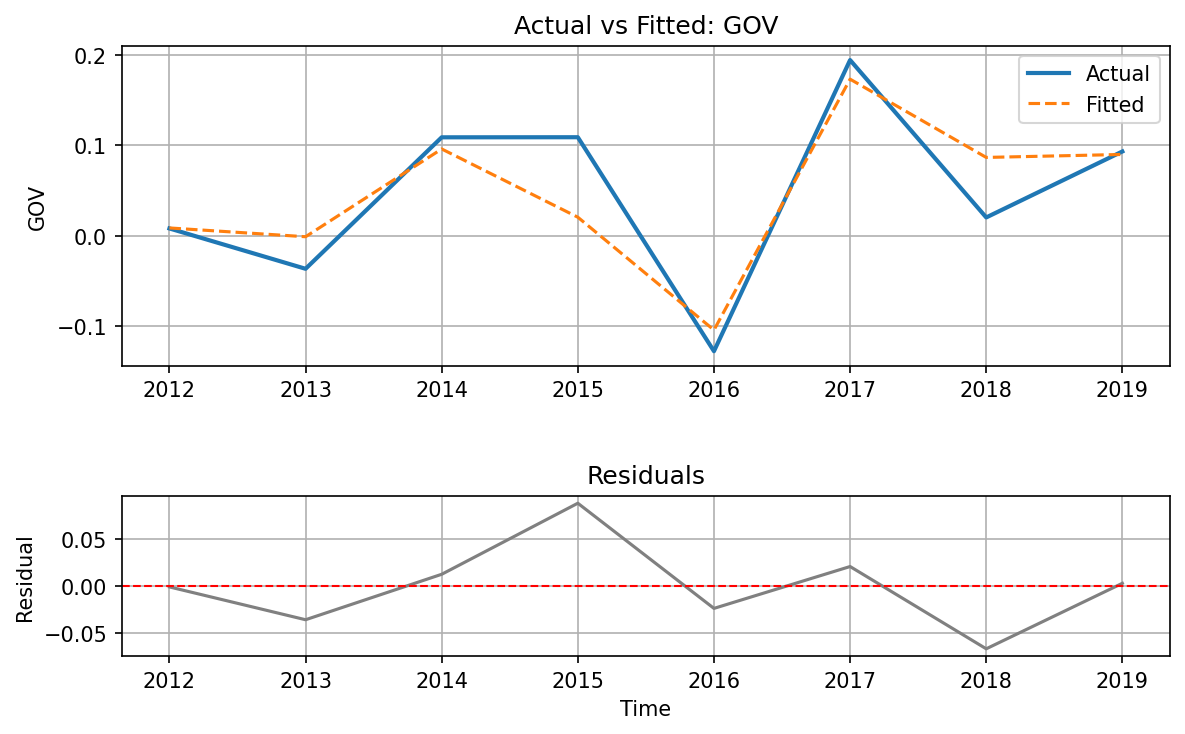

In [18]:
plot_actual_vs_fitted(_gov, figsize=(8, 5))

Without the add factor the `_gov` equation (nor any other behavioural equation) cannot reproduce history.

By setting the add-factors equal to the difference between the fitted equation results and the actual historical results, we can ensure that the model reproduces history. 

Below the call `equations.init_addfactors(npl,2016,2024,show=True,check=True,multiplier=1_000_000)` to calculate the add-factors for every behavioural equation that satisfy the above identity and ensure that the model reproduces history. 

 - npl is the dataframe containing all values the model needs. 
 - 2016,2024 is the time frame for which the add factors should be calculated (in this instance the historical period)
 - show = True: the calculated add factors are displayed
 - check = True: Are the results really aligned ?
 - multiplier=1_000_000 the differences between the results and the values in the initial `DataFrame`

The method returns a `DataFrame` that is a copy of the input `DataFrame` with \_A variables added for each behavioural equation. These are equal to the difference between the data in the initiating `DataFrame` and the fitted value of the equation. For the historical period these are effectively the error term from the econometric equation.

A separate presentation focuses on better understanding of add factors and how to use them most effectively. The below focuses on the command to create and initialize them. 

In the  graph below the residual is the error term in the government consumption equation and is equal to the difference between the fitted value and the actual value for the variable GOV.



In [19]:
baseline = equations.init_addfactors(npl,2016,2024,show=True,check=True,multiplier=1_000)



Add factors to allign  historic values and model results
          CON_A     GOV_A     IMP_A     INV_A
index                                        
2016  -0.007206 -0.023351 -0.060372  0.035381
2017  -0.016078  0.021094  0.117309  0.063518
2018   0.000229 -0.066261  0.079391 -0.008516
2019   0.011734  0.003291 -0.033579  0.027008
2020  -0.033680  0.190651 -0.239601  0.023677
2021   0.040758 -0.016997  0.042459  0.028048
2022   0.043887  0.040650  0.045757 -0.016632
2023  -0.011978  0.036683 -0.180888 -0.111530
2024  -0.001030 -0.013230 -0.115712 -0.058646


Difference between historic values and model results
Multiplied by 1000


,CON,GDE,GOV,IMP,INV,Y
index,,,,,,
2016,0.000000,-4.656613e-07,-6.111804e-07,3.492460e-07,-1.164153e-07,-9.313226e-07
2017,-0.000001,-1.396984e-06,-3.783498e-07,0.000000e+00,3.492460e-07,-1.396984e-06
2018,-0.000003,-2.328306e-06,-3.201421e-07,-4.656613e-07,1.047738e-06,-1.862645e-06
2019,-0.000001,3.259629e-06,4.365575e-07,4.656613e-07,3.841706e-06,2.793968e-06
2020,-0.000003,-9.313226e-06,-4.074536e-07,-3.492460e-06,-5.238689e-06,-5.587935e-06
2021,-0.000002,4.190952e-06,3.783498e-07,2.328306e-06,5.820766e-06,1.862645e-06
2022,-0.000001,-4.656613e-07,2.910383e-07,9.313226e-07,2.328306e-07,-1.396984e-06
2023,0.000000,1.396984e-06,1.455192e-07,2.561137e-06,1.513399e-06,-9.313226e-07
2024,-0.000003,-1.396984e-06,1.746230e-07,1.396984e-06,1.979060e-06,-2.793968e-06


The final table shows us the difference between the input data set and the model solution (times 1000).  Because there were no changes in the input data, it is our hope that the model result would be equal to the input data.

While all the numbers above are not zero they are all less than .00001. Given that these are already multiplied by 1 000, it suggests that the model solution is very close to exactly equal to the input data.

If we want the model to reproduce the current forecast also we will have to calculate add factors for both the historical and forecast periods (as below).

In [20]:
baseline = equations.init_addfactors(npl,2016,2030,show=True,check=True,multiplier=1_000)



Add factors to allign  historic values and model results
          CON_A     GOV_A     IMP_A     INV_A
index                                        
2016  -0.007206 -0.023351 -0.060372  0.035381
2017  -0.016078  0.021094  0.117309  0.063518
2018   0.000229 -0.066261  0.079391 -0.008516
2019   0.011734  0.003291 -0.033579  0.027008
2020  -0.033680  0.190651 -0.239601  0.023677
2021   0.040758 -0.016997  0.042459  0.028048
2022   0.043887  0.040650  0.045757 -0.016632
2023  -0.011978  0.036683 -0.180888 -0.111530
2024  -0.001030 -0.013230 -0.115712 -0.058646
2025   0.015070  0.032896 -0.035197 -0.019915
2026   0.030159  0.022151 -0.036809 -0.017029
2027   0.036629  0.009521 -0.043696 -0.017631
2028   0.036074  0.003362 -0.050096 -0.015356
2029   0.029546  0.006250 -0.053233 -0.008585
2030   0.020478  0.014117 -0.054037  0.000215


Difference between historic values and model results
Multiplied by 1000


,CON,GDE,GOV,IMP,INV,Y
index,,,,,,
2016,0.000000e+00,-4.656613e-07,-6.111804e-07,3.492460e-07,-1.164153e-07,-9.313226e-07
2017,-1.396984e-06,-1.396984e-06,-3.783498e-07,0.000000e+00,3.492460e-07,-1.396984e-06
2018,-3.026798e-06,-2.328306e-06,-3.201421e-07,-4.656613e-07,1.047738e-06,-1.862645e-06
2019,-1.164153e-06,3.259629e-06,4.365575e-07,4.656613e-07,3.841706e-06,2.793968e-06
2020,-3.492460e-06,-9.313226e-06,-4.074536e-07,-3.492460e-06,-5.238689e-06,-5.587935e-06
2021,-2.328306e-06,4.190952e-06,3.783498e-07,2.328306e-06,5.820766e-06,1.862645e-06
2022,-1.396984e-06,-4.656613e-07,2.910383e-07,9.313226e-07,2.328306e-07,-1.396984e-06
2023,0.000000e+00,1.396984e-06,1.455192e-07,2.561137e-06,1.513399e-06,-9.313226e-07
2024,-3.259629e-06,-1.396984e-06,1.746230e-07,1.396984e-06,1.979060e-06,-2.793968e-06


## Solving the model

Below we solve the model, inputting the baseline `DataFrame` that we calculated above. the model is solved once, using the `DataFrame` with add factors.  If the model is balanced and the add_factors well calculated the model should return exactly the same number as were initially inputted.

The df2 calculation indicates that the original value for GDP was indeed GDP returned by the model.

In [21]:
bline = toymodel(baseline,2016,2030,keep="Baseline")

df2=(bline['Y']-baseline['Y'])*1000
df2.loc[2016:2030]





index
2016   -9.313226e-07
2017   -1.396984e-06
2018   -1.862645e-06
2019    2.793968e-06
2020   -5.587935e-06
2021    1.862645e-06
2022   -1.396984e-06
2023   -9.313226e-07
2024   -2.793968e-06
2025   -1.862645e-06
2026   -9.313226e-07
2027   -2.793968e-06
2028   -2.793968e-06
2029   -1.024455e-05
2030    1.210719e-05
Name: Y, dtype: float64


## Model properties

The model object automatically keeps track of many things; including lists of  lists of exogenous variables, endogenous variables, stochastic variables, and identities.

### Variables


#### Exogenous variables

In our model we defined equations for only some variables ```y con gov inv imp   and gde ``` , the remaining variables ```exp ``` and ``` ydisc``` upon which the equations (identity or behavioural) are implicitly defined as exogenous variables.  The model object automatically keeps track of the variables in the model and classfies them either as identities, stochastic, or exogenous. Endogenous variables are a superset of identities and stochastic variables.

The command ```modelname.exogene``` extracts from the model object a string containing a space-delimited list of all the exogenous variables.

Thus for our model we can create a string ```exogs``` and fill it with the list from the model object.

In [22]:
exogs=toymodel.exogene
exogs


{'CON_A',
 'CON_D',
 'CON_X',
 'EXP',
 'GOV_A',
 'GOV_D',
 'GOV_X',
 'IMP_A',
 'IMP_D',
 'IMP_X',
 'INV_A',
 'INV_D',
 'INV_X',
 'YDISC'}

#### behavioural variables

We can similarly extract a list of stochastic equations.

In [23]:
stoch=toymodel.model_var_stoc
stoch

{'CON', 'GOV', 'IMP', 'INV'}

#### Identities

The `model_var_ident` command extracts a list of all the variables defined by an identity in the model object,
```modelname.model_var_ident```


In [24]:
idents=toymodel.model_var_ident
idents

{'GDE', 'Y'}

### Equations

The classifications of variables are closely related to the nature of the equations (identitiesl behavioural, or exogesou if no equation) that determine their values in model simulation.  The routines below provide information on the individual equations or equation collection.

#### The `.clean` property
The `.clean` property returns a multi-line string of the equations included in the model without estimated parameter values.

In [25]:
# note the collection contains these equations
print(equations.clean)

DLOG(CON)= -C__2*(LOG(CON(-1))-LOG(Y(-1))-LOG(ABS(C__1)))+C__10*DLOG(Y)
DLOG(GOV)=-0.5*(LOG(GOV(-1))-LOG(Y(-1))-LOG(ABS(C__1))) + C__10*DLOG(Y)
DLOG(INV)=-.2*(LOG(INV(-1))-LOG(Y(-1)-GOV(-1))-LOG(ABS(C__1)))+C__10*DLOG(Y-GOV)
DLOG(IMP)=-0.2*(LOG(IMP(-1))-LOG(GDE(-1))-LOG(ABS(C__1)))+1.*DLOG(GDE)
Y=CON+INV+GOV+EXP-IMP+YDISC
GDE=CON+INV+GOV


#### The `.clean_normal` property
The `.clean_normal` property returns a multi-line string of the normalized version of the equations (level of dependent variable equals RHS expresion) included in the model with estimated (and imposed) parameter values.

In [26]:
print(equations.clean_normal)

CON = CON(-1)*EXP( (-(0.4416699413)*(LOG(CON(-1))-LOG(Y(-1))-LOG(ABS((0.8842598155))))+(-0.0971117759)*((LOG(Y))-(LOG(Y(-1))))) )
GOV = GOV(-1)*EXP( (-0.5*(LOG(GOV(-1))-LOG(Y(-1))-LOG(ABS((0.0658709993))))+(2.5863557625)*((LOG(Y))-(LOG(Y(-1))))) )
INV = INV(-1)*EXP( (-.2*(LOG(INV(-1))-LOG(Y(-1)-GOV(-1))-LOG(ABS((0.3059181757))))+(2.0621068986)*((LOG(Y-GOV))-(LOG(Y(-1)-GOV(-1))))) )
IMP = IMP(-1)*EXP( (-0.2*(LOG(IMP(-1))-LOG(GDE(-1))-LOG(ABS((0.4239118898))))+1.*((LOG(GDE))-(LOG(GDE(-1))))) )
Y = CON+INV+GOV+EXP-IMP+YDISC
GDE = CON+INV+GOV


#### The `.eqs_norm()` property
The `.eqs_norm()` property also shows the normalized version of the equations, but includes various model additions, like the \_D and \_X variables (used for exogenizing equations) and the add factors.

In [27]:
print(equations.eqs_norm)

<STOC,DAMP> CON = (CON(-1)*EXP(CON_A+ (-(0.4416699413)*(LOG(CON(-1))-LOG(Y(-1))-LOG(ABS((0.8842598155))))+(-0.0971117759)*((LOG(Y))-(LOG(Y(-1))))) )) * (1-CON_D)+ CON_X*CON_D 
<STOC,DAMP> GOV = (GOV(-1)*EXP(GOV_A+ (-0.5*(LOG(GOV(-1))-LOG(Y(-1))-LOG(ABS((0.0658709993))))+(2.5863557625)*((LOG(Y))-(LOG(Y(-1))))) )) * (1-GOV_D)+ GOV_X*GOV_D 
<STOC,DAMP> INV = (INV(-1)*EXP(INV_A+ (-.2*(LOG(INV(-1))-LOG(Y(-1)-GOV(-1))-LOG(ABS((0.3059181757))))+(2.0621068986)*((LOG(Y-GOV))-(LOG(Y(-1)-GOV(-1))))) )) * (1-INV_D)+ INV_X*INV_D 
<STOC,DAMP> IMP = (IMP(-1)*EXP(IMP_A+ (-0.2*(LOG(IMP(-1))-LOG(GDE(-1))-LOG(ABS((0.4239118898))))+1.*((LOG(GDE))-(LOG(GDE(-1))))) )) * (1-IMP_D)+ IMP_X*IMP_D 
<IDENT> Y = CON+INV+GOV+EXP-IMP+YDISC
<IDENT> GDE = CON+INV+GOV


## Graphical representation of the model's equations

The `.drawmodel()` method produces a visual representation of the linkages between variables in the model, with exogenous variables in yellow, endogenous ones in blue.

The below displays the structure of the enhanced model and the linkages between variables.  The \_D and \_X variables are generated and are used to exogenize (turn off) equations when desired (when G\_D =1 then the equation for g resolves impliy to the value of G\_X.

By the same token the \_A variables are added to the equations of stochastic variables and are generated by the model when it is trained on a data set. For the moment it is merely a system of equations without any actual data.

In [28]:
toymodel.drawmodel(browser=False,size=(10,10),lag=0) 

The `.drawmodel()` method for the equations collection is somewhat cleaner, omitting the \_X, \_D, \_A variables.

In [29]:
equations.model_clean.drawmodel(lag=0) 

And including lags (green variables below). In the clean version there are still only 2 exogenous variables. 

In [30]:
equations.model_clean.drawmodel(lag=1) 

the plotadjacency() method displays an adjacency matrix of the model, indicating which variables are functions of which other variables and notably those that exist in a feedback block where the value of one variable is determined by the value of a second, which in turn is directly or inidrectly determined by the valye of the first.

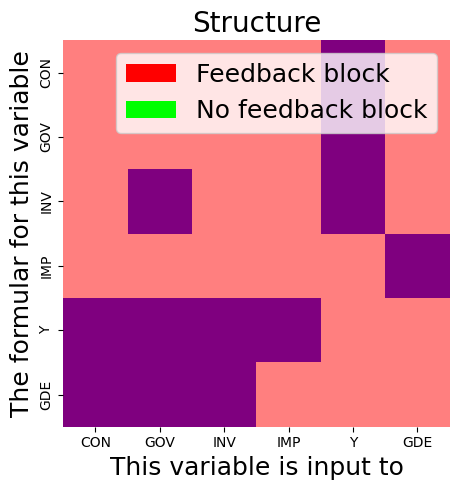

In [31]:
toymodel.plotadjacency() ;

## Scenario analysis

`Modelflow` includes a wide range of reporting and simulation features that are explained in much greater detail in Burns and Hansen (2025).

The below provides a very brief illustration of the syntax needed to run a simulation.


### Using Keep to "register" a baseline simulation

The Keep option enables a range of reporting options in the model object (tables and graphs, along with comparisons of simulation results with those from other simulations).  Below we once again run a simulation on the original `DataFrame` with no change in the input `DataFrame` -- which as noted above should **and does** return the same result as the baseline.

The keep option here saves the result dataframe and gives it the text name 'Baseline'.

In [32]:
bline = toymodel(baseline,2016,2030,keep='Baseline',tol=.00000001)


#### Create an alternative scenario.
To make a new scenario a new dataframe i s created by updating an exogenous (or exogenized) variable in the baseline dataframe. 

In this instance the EXP variable (real exports) is an exogenous variable and is increased by 10% (multiplied by 1.1) between 2024 to 2026.

This is achieved by using the `ModelFlow` `.upd()` method (explained in more detail Burns and Hansen (2025)), In the example below we generate a new `DataFrame` Gov10 as a copy of the bline `DataFrame` but with the EXP variable increased by 10% between 2024 and 2026.




In [33]:
Exp10 = bline.upd('<2024 2026> exp * 1.1')


Below we show the ratio of the initial exports value (`bline`) and the revised one (`Gov10`), which is indeed up 10% in each year between 2024 and 2026.

In [34]:
100*Exp10.loc[2020:2030,'EXP']/bline.loc[2020:2030,'EXP']

index
2020    100.0
2021    100.0
2022    100.0
2023    100.0
2024    110.0
2025    110.0
2026    110.0
2027    100.0
2028    100.0
2029    100.0
2030    100.0
Name: EXP, dtype: float64

Now the model can be run with the new `DataFrame` as input, with the `keep=` with the scenario name.  The results in the case below will be stored in the model object identified by the text `"Increase exports by 10% for 2025-26"`.

In [35]:
result = toymodel(Exp10,2016,2030,keep="Increase exports by 10% for 2025-26")

Because the keep option was used we can generate a nice comparison chart using the plot outline of `ModelFlow`,

In [36]:
toymodel['y con inv gov exp imp'].rplot(datatype= 'difpctlevel',samefig=1,by_var=1,samey=True,legend=False,scenarios='*') 

Accordion(children=(HTML(value='<?xml version="1.0" encoding="utf-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "…

### Solve options



| Parameter           | Type           |  Description   |
|:---------------------|:----------------|:----------------|
| `do_calc_add_factor`| bool           |  Determines whether to calculate the add factors. Used to calculate add-factors to ensure the model exactly reproduces the submitted data set.  Default is True. |
| `reset_options`     | bool           |  If True, the previous options will be reset. Default is False. |
| `solver`            | str            |  Specifies the solver to be used. Default is chosen based on the model's properties. (Typically `sim` (Gauss-seidel) for WB models, or `newton-stacked` for forward-looking models.)|
| `silent`            | bool           |  If True, the solver runs silently without printing outputs to the console. Default is True. |
| `keep`              | str            |  If provided, keeps the solutions. Behavior depends on the `keep_variables` option. |
| `keep_variables`    | str, list of str| Specifies which variables to keep if the `keep` option is provided. Default is '\*' - to keep all variables. |
| `*args`             | various        |  Variable length argument list. Usual the `Dataframe` and start and end year|
| `**kwargs`          | various        |  Arbitrary keyword arguments. These are provided to the actual solver |

## Different kinds of scenarios



Four types of simulation methods are provided by `ModelFlow`:

1) **Permanent Exogenous Shocks**: These involve either *shocking an exogenous variable* (say World oil prices) or *deactivating an equation* and treating its dependent variable as if it were exogenous and shocking it directly.
2) **Endogenous Shocks**: In these shocks, a behavioral equation is left active, but its *add-factor is shocked* in order to impact its trajectory. This might be used when an external shock is expected, but the analyst wants the subsequent (and even contemporaneous) behavior of the variable to react to second-round effects that occur in the model (i.e., an increase in investment by one firm could be modelled using an add-factor, but as GDP rises, other firms would normally also want to increase their investment to meet the additional demand. By using the add-factor this second order effect is enabled).
3) **Temporary Exogenous Shocks**: Here a behavioral equation can be temporarily deactivated — give the endogenous variable an initial shock by setting its level directly to a specific level for a given period — but then reactivated in subsequent periods so that the variable's trajectory is affected by second- and third-round effects of the initial shock. This differs from the add-factor shock in that there is no endogenous reaction of the shocked variable during the period it is exogenized.
4) **Mixed Scenarios**: More complex scenarios that combine one or more shocks.


How the model will behave will depend on how the shock is administered.

The discussion in Chapter 11 of Burns and Hansen (2025) presents detailed examples and comparisons of the results from simulations using each of these approaches.

